# Diabetes Disease Prediction System
## Production-Ready Medical Machine Learning Pipeline

**Dataset:** Pima Indians Diabetes Dataset  
**Objective:** Build a medically-sound ML system with ≥85% accuracy and high recall  

### Key Highlights
- Intelligent handling of medically invalid zeros
- Feature engineering using medical domain knowledge
- Class imbalance handling
- Multiple ML models with hyperparameter tuning
- Medical-grade evaluation metrics
- Deployment-ready prediction system


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.impute import KNNImputer

import pickle
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)


## Step 1: Load Dataset

We load the Pima Indians Diabetes dataset and perform an initial sanity check.


In [12]:
df = pd.read_csv("diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Dataset Overview
- 768 samples
- 8 clinical features
- 1 binary target variable (`Outcome`)


In [13]:
df.shape, df.info(), df.describe()

df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Step 2: Exploratory Data Analysis (EDA)

We analyze:
- Class imbalance
- Medically invalid zero values
- Feature distributions
- Feature correlations


In [14]:
df["Outcome"].value_counts()


Outcome
0    500
1    268
Name: count, dtype: int64

In [15]:
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in zero_cols:
    print(col, (df[col] == 0).sum())


Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11


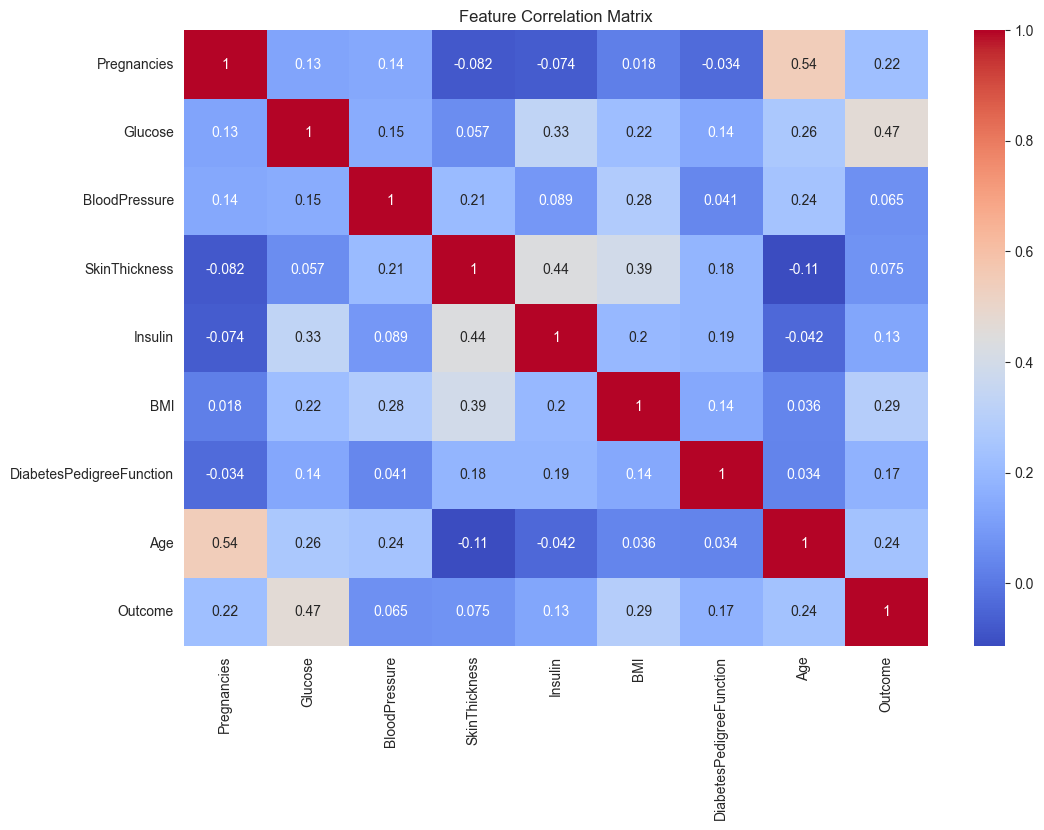

In [16]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


## Step 3: Data Cleaning & Imputation

Medically impossible zero values are treated as missing data.
We use **KNN Imputation** to preserve feature relationships.


In [17]:
df_clean = df.copy()

for col in zero_cols:
    df_clean[col] = df_clean[col].replace(0, np.nan)

X_knn = df_clean.drop("Outcome", axis=1)
y = df_clean["Outcome"]

imputer = KNNImputer(n_neighbors=5)
X_knn_imputed = pd.DataFrame(imputer.fit_transform(X_knn), columns=X_knn.columns)

df_clean = pd.concat([X_knn_imputed, y.reset_index(drop=True)], axis=1)


## Step 4: Feature Engineering

Medical domain-driven features:
- BMI category (WHO)
- Age groups
- Glucose risk levels
- Interaction features


In [18]:
df_fe = df_clean.copy()

df_fe["BMI_Category"] = pd.cut(df_fe["BMI"], [0,18.5,25,30,100], labels=[0,1,2,3]).astype(int)
df_fe["Age_Group"] = pd.cut(df_fe["Age"], [0,30,45,60,100], labels=[0,1,2,3]).astype(int)
df_fe["Glucose_Risk"] = pd.cut(df_fe["Glucose"], [0,100,125,200], labels=[0,1,2]).astype(int)

df_fe["High_Pregnancies"] = (df_fe["Pregnancies"] >= 6).astype(int)
df_fe["BMI_Age_Interaction"] = df_fe["BMI"] * df_fe["Age"] / 100
df_fe["Glucose_BMI_Ratio"] = df_fe["Glucose"] / df_fe["BMI"]

df_fe.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Age_Group,Glucose_Risk,High_Pregnancies,BMI_Age_Interaction,Glucose_BMI_Ratio
0,6.0,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1,3,2,2,1,16.800,4.404762
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0,2,1,0,0,8.246,3.195489
2,8.0,183.0,64.0,25.8,164.6,23.3,0.672,32.0,1,1,1,2,1,7.456,7.854077
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,2,0,0,0,5.901,3.167260
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1,3,1,2,0,14.223,3.178654


## Step 5: Train-Test Split (Stratified)


In [19]:
X = df_fe.drop("Outcome", axis=1)
y = df_fe["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Step 6: Feature Scaling

Scaling is done **after split** to avoid data leakage.


In [20]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Step 7: Model Training & Hyperparameter Tuning

Models:
- Logistic Regression
- SVM (RBF)
- Random Forest
- Gradient Boosting


In [21]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train_scaled, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

## Step 8: Model Evaluation (Medical Metrics)


In [23]:
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Accuracy: 0.7532467532467533
Recall: 0.6296296296296297
Precision: 0.6538461538461539
ROC-AUC: 0.8290740740740741
